## Bayesian estimates of (Mr, [Fe/H], Ar) using SDSS colors and TRILEGAL priors

### speed: about 0.1-0.2 sec/star 

### with known Ar: 2D version runs in 4 milisec/star

In [1]:
%matplotlib inline
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde
# from scipy import interpolate 
from scipy.interpolate import griddata

In [180]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
sys.path.append('../src')
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt

### read photometric catalog with stars

In [3]:
## read TRILEGAL sim-based data file, augmented with LSST colors 
## the input data are limited to 0.2 < g-i < 3.0 and
## -2.5 < FeH < 0 and Mr > -1.0 and log(g) < 7 and rmag < 26 
sims = lt.readTRILEGALLSST(inTLfile='../data/simCatalog_three_pix_triout_chiTest4.txt', chiTest=True)
sims[0:2]

READING FROM ../data/simCatalog_three_pix_triout_chiTest4.txt
814450 read from ../data/simCatalog_three_pix_triout_chiTest4.txt


glon,glat,comp,logg,FeH,Mr,DM,Ar,rmag0,ug0,gr0,ri0,iz0,rmag,ug,gr,ri,iz,uErr,gErr,rErr,iErr,zErr,ugSL,grSL,riSL,izSL,ugErrSL,grErrSL,riErrSL,izErrSL,gi0,gi,gmag,umag,imag,zmag,ugErr,grErr,riErr,izErr
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.94839984,-45.11469269,1,4.95,-0.51,11.44,8.9,0.096,20.43,2.458,1.396,1.355,0.705,20.43,2.497,1.435,1.378,0.724,0.06,0.006,0.005,0.005,0.005,2.549,1.434,1.378,0.729,0.063,0.008,0.007,0.007,2.751,2.8129999999999997,21.865,24.362,19.052,18.328,0.060299253726725344,0.0078102496759066544,0.007071067811865475,0.007071067811865475
0.21957318,-44.95205688,1,5.07,-0.49,13.04,8.65,0.12,21.81,2.58,1.478,1.723,0.943,21.82,2.629,1.526,1.752,0.967,0.249,0.011,0.006,0.005,0.005,2.369,1.547,1.756,0.956,0.2,0.013,0.008,0.007,3.201,3.278,23.346,25.975,20.068,19.101000000000003,0.24924285345822858,0.012529964086141668,0.0078102496759066544,0.007071067811865475


In [4]:
print(np.min(sims['Mr']), np.max(sims['Mr']))   # priors only support Mr<15; need to rerun priors

-1.0 15.04


### read stellar locus parametrization

In [5]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False)
## select the color range where we expect main sequence and red giants
# this fails, need to rerun priors for Mr>15
# OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.8)]  # 3.8 to get beyond MrMax in sims
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)
OKlocus[0:2]

Mr,FeH,ug,gr,ri,iz,zy,gi
float64,float64,float64,float64,float64,float64,float64,float64
-1.0,-2.5,1.3805,0.578,0.265,0.1681,0.0803,0.843
-0.99,-2.5,1.3793,0.5776,0.2648,0.1679,0.0802,0.8424


In [6]:
print(np.min(LSSTlocus['Mr']), np.min(OKlocus['Mr']))
print(np.max(LSSTlocus['Mr']), np.max(OKlocus['Mr']))

-1.0 -1.0
28.0 14.58


### process data...

In [198]:
### 
catalog = sims
fitColors = ('ug', 'gr', 'ri', 'iz')  
priorsRootName = '../data/TRILEGALpriors/priors'
if (0):
    # maximum resolution version
    locusData = OKlocus  
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3D.txt'
else:
    ## subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)
    kMr = 10
    kFeH = 2 
    locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3Dsparse10_2.txt'

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


In [199]:
### make 3D locus list with three ArGrid limits and resolutions
timeStart = !date +%s  
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Made model locus3D list in', runTime,'seconds.')

Made model locus3D list in 4 seconds.


 *** 3D Bayes results for star i= 100592
r mag: 20.38 g-r: 0.474
Mr: 4.521381434007792  +-  0.30204335173302443
FeH: -0.9864917239302899  +-  0.10189896142866414
Ar: 0.38892432982611685  +-  0.06565803528930408
Mr drop in entropy: -21.971807722914072
FeH drop in entropy: -19.34108614857394
Ar drop in entropy: -115.40865544524274


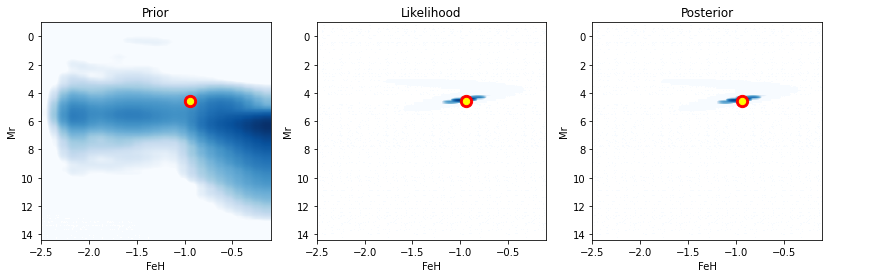

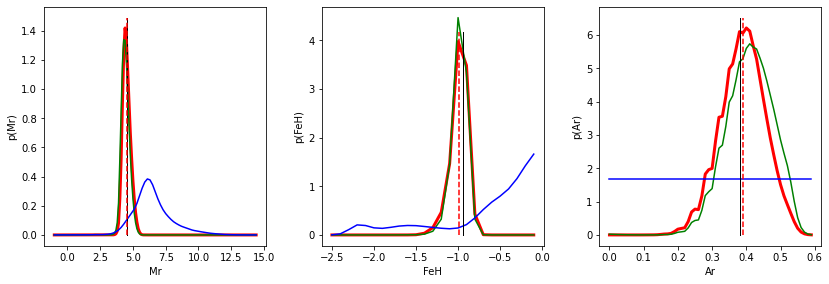

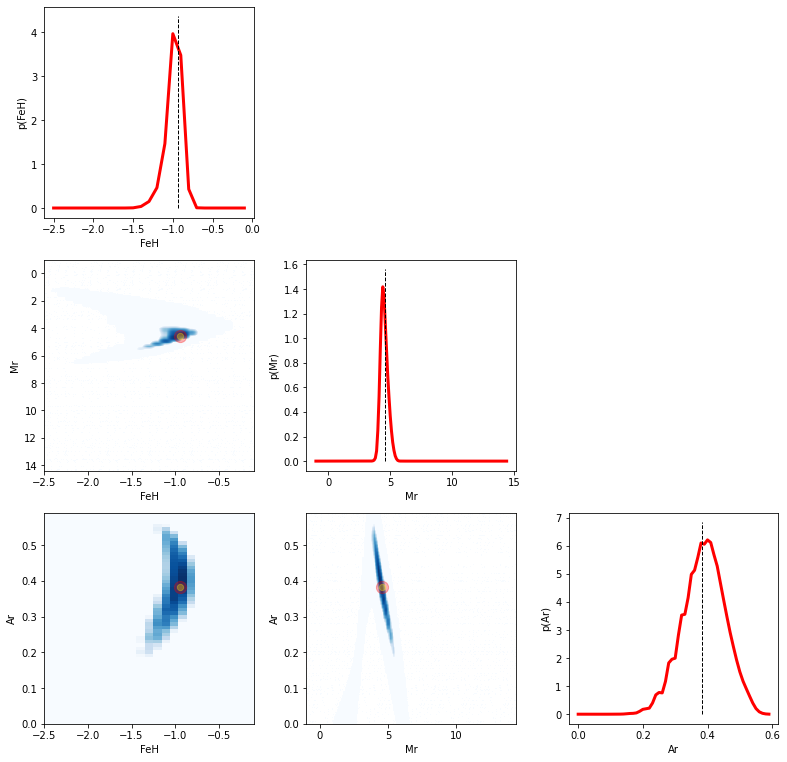

Finished in 3 seconds.


In [202]:
iStart = 100592  # for testing option restrictLocus=True in bt.makeBayesEstimates3D
iEnd = -1    # if <0: do all stars
myStars = [0, 10, 100, 195, 100592, 710592, 1000, 10000]  # for method illustration, make plots for these stars 
# myStars = [] # no plots when measuring speed
verb=True

if True: 
    ### TESTS: 
    iEnd = iStart + 1
    outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates3Ddiscard.txt'
    ############
               
timeStart = !date +%s  
bt.makeBayesEstimates3D(catalog, fitColors, locusData, locus3DList, ArGridList, priorsRootName, outfile, iStart, iEnd, myStars, verbose=verb)
# 2D version, where prior for Ar is set to the true value for each star
# bt.makeBayesEstimates2D(catalog, fitColors, OKlocus, priorsRootName, outfile, iStart, iEnd, myStars, verbose=False)
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Finished in', runTime, 'seconds.')

In [139]:
# for processed stars
if (iEnd < iStart):
    iStart = 0
    iEnd = np.size(catalog)
simsP = sims[iStart:iEnd]
simsP['dMr'] = simsP['Mr'] - simsP['MrEst']
simsP['dMrNorm'] = simsP['dMr'] / simsP['MrEstUnc'] 
simsP['dFeH'] = simsP['FeH'] - simsP['FeHEst']
simsP['dFeHNorm'] = simsP['dFeH'] / simsP['FeHEstUnc'] 
simsP['dAr'] = simsP['Ar'] - simsP['ArEst']
simsP['dArNorm'] = simsP['dAr'] / simsP['ArEstUnc'] 
print('sample size:', np.size(simsP))
print('Mr  FeH  Ar:')
print('median uncertainty:', np.median(simsP['MrEstUnc']), np.median(simsP['FeHEstUnc']), np.median(simsP['ArEstUnc']))
print('median error:', np.median(simsP['dMr']), np.median(simsP['dFeH']), np.median(simsP['dAr']))
print('std for chi:', np.std(simsP['dMrNorm']), np.std(simsP['dFeHNorm']), np.std(simsP['dArNorm']))

sample size: 814450
Mr  FeH  Ar:
median uncertainty: 0.28306532031095033 0.28231900051793274 0.05567551284873029
median error: 0.02695556012561484 0.011073315313001611 -0.010059900572970324
std for chi: 1.0431738285717302 1.0116512389726864 0.8480515713878305


In [12]:
# SPEED TEST (with all stars):
# 3D finished in 253673 seconds: 0.312 sec/star or 11550 star/hr (or 4 days for a million stars)
# 3D with 10-2 sparse models: 8657 seconds, or ~30 times faster (10 milisec/star)
# 2D: 

In [153]:
### component speed tests: 1000 stars (so sec -> milisec)
# 0) full computation: 161 sec  (3 sec for 2D)
# 1) chi2 computation: 22 sec  
# 2) likeGrid computation: 16 sec (for simple exp computation)
# 3) priors: 15 sec 
# 4) posterior: 7 sec (for posterior = prior * likelihood)
# 5) marginal distributions and stats: 8 sec 
# 6) writing: <1 sec 
# 7) initial pre-loop setup: 4 sec
##
## tests of subsampling: linear scaling with the # of grid points
## kSubsample  makeLocus  total runtime
#    1  1         97          128
#    1  2         47           63
#    2  1         49           64
#    5  1         20           26 
#    5  2          9           14
#   10  2          5            8 

In [203]:
# interesting stars for further investigation and illustration
# i=195 tri-modal posterior for Ar 
# i=100592 nice turn-off with nice parameter covariances - rerun at higher resolution (no subsampling)